# Exchange rate forecasting

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

In [38]:
df = pd.read_csv(r'USD_INR Historical Data (2).csv')

In [39]:
missing_values = df['Price'].isnull().sum()
df['Price'].fillna(df['Price'].mean(), inplace=True)

/tmp/ipykernel_5557/3087342875.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].fillna(df['Price'].mean(), inplace=True)


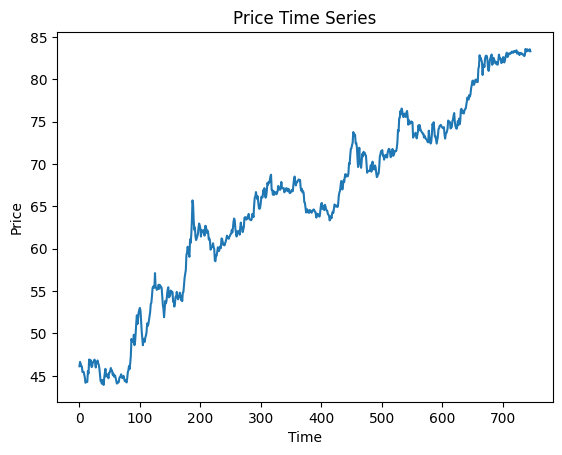

In [40]:
df = df[::-1].reset_index(drop=True)
plt.plot(df['Price'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price Time Series')
plt.show()

In [59]:
X = np.array(df.index).reshape(-1, 1)  # Using timestamps as features
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Forecasting
y_pred = model.predict(X_test)
print("Date\t\tActual Price\tPredicted Price")
for date, actual, predicted in zip(y_test.index, y_test, y_pred):
    print(f"{date}\t{actual:.2f}\t\t{predicted:.2f}")

# Calculating MSE, RMSE, and R2 score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nMean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Date		Actual Price	Predicted Price
208	0.47		0.34
259	0.45		0.40
97	0.20		0.20
148	0.26		0.27
395	0.51		0.57
487	0.65		0.69
234	0.41		0.37
181	0.39		0.31
526	0.72		0.74
367	0.58		0.54
260	0.44		0.41
368	0.58		0.54
523	0.70		0.73
396	0.51		0.58
351	0.58		0.52
77	0.01		0.18
609	0.76		0.84
420	0.51		0.61
174	0.32		0.30
743	1.00		1.01
39	0.01		0.13
620	0.81		0.85
375	0.51		0.55
665	0.97		0.91
650	0.90		0.89
296	0.54		0.45
192	0.44		0.32
538	0.81		0.75
626	0.78		0.86
231	0.40		0.37
299	0.53		0.45
416	0.50		0.60
346	0.58		0.51
480	0.64		0.68
76	0.01		0.18
81	0.04		0.18
549	0.78		0.77
314	0.60		0.47
323	0.57		0.48
425	0.53		0.61
33	0.05		0.12
450	0.70		0.64
554	0.74		0.77
78	0.01		0.18
464	0.66		0.66
66	0.02		0.16
388	0.52		0.57
319	0.58		0.48
10	0.01		0.09
725	0.99		0.98
482	0.65		0.68
338	0.59		0.50
399	0.53		0.58
101	0.22		0.21
247	0.43		0.39
223	0.40		0.36
118	0.24		0.23
54	0.04		0.15
158	0.24		0.28
586	0.78		0.81
713	0.99		0.97
239	0.42		0.38
211	0.45		0.34
715	0.99		0.97
451	0.71		0.64


In [52]:

target_column = "Price"

# Scale the target column (recommended for RNNs)
scaler = MinMaxScaler(feature_range=(0, 1))
df[target_column] = scaler.fit_transform(df[[target_column]])

# Create sequences for training (look-back window)
look_back = 30  # Adjust this value based on your data
sequences = []
for i in range(look_back, len(df)):
    sequence = df[target_column][i-look_back:i]
    sequences.append(sequence)

# Convert sequences to NumPy arrays
sequences = np.array(sequences)

# Split data into training and testing sets
train_size = int(len(sequences) * 0.8)  # Adjust split ratio as needed
train_data, test_data = sequences[:train_size], sequences[train_size:]

# Reshape data for LSTM (samples, time steps, features)
X_train = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
X_test = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model (adjust learning rate or optimizer if needed)
model.compile(loss="mse", optimizer="adam")

# Train the model
model.fit(X_train, train_data[:, -1], epochs=100, batch_size=32)  # Predict last value in sequence

# Make predictions on test data
test_predictions = model.predict(X_test)

# Invert scaling for predictions
test_predictions = scaler.inverse_transform(test_predictions)

# Calculate error metrics
actual_prices = df[target_column][look_back + train_size:]  # Get actual test prices
rmse = mean_squared_error(actual_prices, test_predictions)
mae = mean_absolute_error(actual_prices, test_predictions)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Epoch 1/100


/usr/local/python/3.10.13/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0680
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0062
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.9172e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.2785e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 

In [43]:
last_sequence = X_test[-1]
last_sequence = last_sequence[-30:]
last_sequence = last_sequence.reshape(1, 30, 1)
next_day_prediction = model.predict(last_sequence)
next_day_prediction = scaler.inverse_transform(next_day_prediction)
print("Forecast for the next day:", next_day_prediction[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Forecast for the next day: 83.42123


TypeError: unhashable type: 'numpy.ndarray'

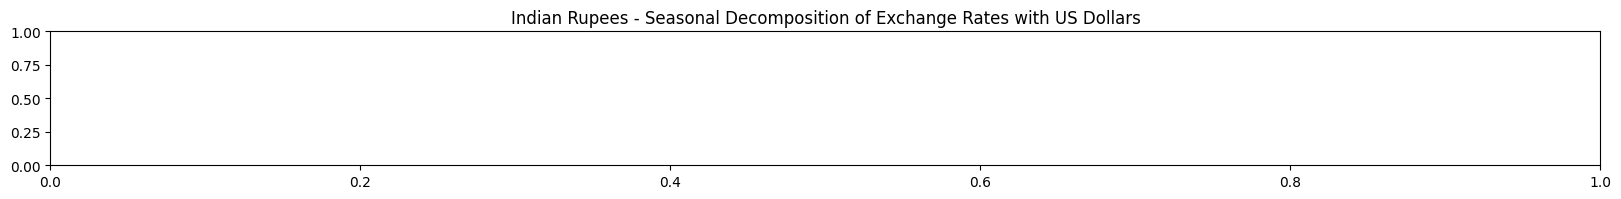

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose into trend, seasonal, and residual components
ind_decomposition = seasonal_decompose(df['Price'], model='additive', period = 12)
ind_trend =ind_decomposition.trend
ind_seasonal = ind_decomposition.seasonal
ind_residual = ind_decomposition.resid

# Plot the deconposition
plt.figure(figsize = (20,8))
plt.subplot(411)
plt.title("Indian Rupees - Seasonal Decomposition of Exchange Rates with US Dollars")
plt.plot(df, label = "Original")
plt.legend(loc = "upper left")
plt.subplot(412)
plt.plot(ind_trend, label = "Trend")
plt.legend(loc = "upper left")
plt.subplot(413)
plt.plot(ind_seasonal, label = "Seasonality")
plt.legend(loc = "upper left")
plt.subplot(414)
plt.plot(ind_residual, label = "Residual")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()
